# Compute FWHM of PSTHs for 11 and 30Hz

Only PSTHs with a significance level below 0.05 are used

In [1]:
%load_ext autoreload
%autoreload 2

In [243]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import expipe
import os
import pathlib
import numpy as np
import exdir
import pandas as pd
import optogenetics as og
import quantities as pq
import shutil
from distutils.dir_util import copy_tree
import seaborn as sns
from functools import reduce
from septum_mec.analysis.stimulus_response import stimulus_response_latency, compute_response
import scipy.stats
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

%matplotlib notebook

In [173]:
std_gaussian_kde = 0.04
window_size = 0.03
tmin = 0. # delay to compute FWHM after stimulus onset

In [174]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [248]:
output = pathlib.Path('output/stimulus-response-fwhm')
(output / 'data').mkdir(parents=True, exist_ok=True)
(output / 'figures').mkdir(parents=True, exist_ok=True)
(output / 'statistics').mkdir(parents=True, exist_ok=True)

In [176]:
# identify_neurons = actions['identify-neurons']
# units = pd.read_csv(identify_neurons.data_path('units'))

In [177]:
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')

In [178]:
session_units

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,date,entity_date,Hz11,Hz30,channel_group,max_depth_delta,max_dissimilarity,unit_id,unit_idnum,unit_name
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,60319,1849-060319,False,True,1,100,0.05,f129d848-ebee-4555-965f-420e402eb820,703,104
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,60319,1849-060319,False,True,1,100,0.05,b50f3878-32aa-40e9-8753-9f401ef32a23,704,108
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,60319,1849-060319,False,True,1,100,0.05,b1626e1a-0469-4ee0-a812-88ee18accd39,705,85
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,60319,1849-060319,False,True,1,100,0.05,feb62d54-f173-4a3c-939c-8c1465e71b0f,706,94
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,60319,1849-060319,False,True,1,100,0.05,3498a09b-b943-4917-866a-8910dbcfd0cd,707,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,10719,1833-010719,True,False,5,100,0.05,3d7d6b0e-bf56-48c3-83f7-b8a1735e5656,189,221
1280,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,10719,1833-010719,True,False,6,100,0.05,5882f4cb-a5f3-4ade-8261-22cc0a55e011,223,225
1281,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,10719,1833-010719,True,False,7,100,0.05,81538188-ccfa-4872-982f-951d03409c9b,294,217
1282,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,10719,1833-010719,True,False,7,100,0.05,24a13971-f609-4460-9020-f8b4d02de336,296,211


In [179]:
stim_resp = actions["stimulus-response"]
stim_resp = pd.read_csv(stim_resp.data_path("results"))

In [180]:
session_units_stim = pd.merge(session_units, stim_resp, on=['action', 'unit_name', 'channel_group'])

In [181]:
# use baseline==False and p_e_peak < 0.05
session_units_stim = session_units_stim[session_units_stim.baseline == False]
session_units_sig = session_units_stim[session_units_stim.p_e_peak < 0.05]

In [182]:
len(session_units_sig)

222

In [183]:
def compute_fwhm(psth, times, t_min=None):
    """
    Compute PSTH. The function handles a single peak or multiple peaks. In the latter case, the peak containing the max peak is used
    """
    times_accepted = times > tmin
    max_idx = np.argmax(psth[times_accepted])
    idxs_greater = np.where(psth[times_accepted] > 0.5 * np.ptp(psth[times_accepted]))[0]
    
    if np.all(np.diff(idxs_greater) == 1):
        fwhm = times[times_accepted][idxs_greater[-1]] - times[times_accepted][idxs_greater[0]]
    else:
        # deal with multiple peaks. when multiple peaks are found, the one containing max_idx is used
        diff_splits = np.where((np.diff(idxs_greater) == 1) == False)[0]
        idxs_list = []
        for i, ds in enumerate(diff_splits):
            if i == 0:
                idxs_list.append(idxs_greater[:ds+1])
            elif i < len(diff_splits):
                idxs_list.append(idxs_greater[diff_splits[i-1]+1:ds+1])
        idxs_list.append(idxs_greater[ds+1:])
        
        for idxs in idxs_list:
            if max_idx in idxs:
                fwhm = times[times_accepted][idxs[-1]] - times[times_accepted][idxs[0]]
        
    return fwhm

In [184]:
times = np.arange(-0.005, window_size, 1e-4)
tmin = 0.005
psths = []
fwhms = []
for i, row in tqdm(session_units_sig.iterrows(), total=len(session_units_sig)):
    action_id = row['action']
    channel_group = row['channel_group']
    unit_name = row['unit_name']
    name = f'{action_id}_{channel_group}_{unit_name}'
    spike_times = data_loader.spike_train(action_id, channel_group, unit_name)
    
    spike_times = np.array(spike_times)
    
    stim_times = data_loader.stim_times(action_id)
    
    if stim_times is None:
        continue
    
    stim_times = np.array(stim_times)
    
    _, spikes, kernel, p_e, p_i = stimulus_response_latency(
        spike_times, stim_times, window_size, std_gaussian_kde)
    
    if all(np.isnan([p_e, p_i])):
        continue
    
    psths.append(kernel(times))
    fwhm = compute_fwhm(kernel(times), times, tmin)
    fwhms.append(fwhm)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

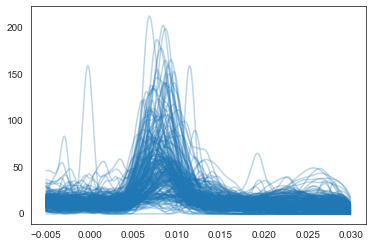

In [185]:
# Quality control
fig = plt.figure()
for psth in psths:
    plt.plot(times, psth, color='C0', alpha=0.3)

In [186]:
#session_units_sig['psth'] = psths
session_units_sig['fwhm'] = fwhms

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Plot FWHM grouped by stimulation frequency

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

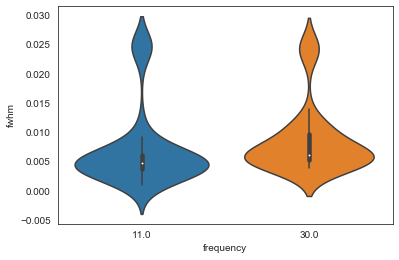

In [188]:
sns.violinplot(data=session_units_sig, x='frequency', y='fwhm')

# stats

In [204]:
statistics_action = actions['calculate-statistics']
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(session_units_sig, statistics_results, how='left')

In [205]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
quantiles_95.head()

,border_score,gridness,head_mean_ang,head_mean_vec_len,information_rate,speed_score,action,channel_group,unit_name
0,0.348023,0.275109,3.012689,0.086792,0.707197,0.149071,1833-010719-1,0.0,127.0
1,0.362380,0.166475,3.133138,0.037271,0.482486,0.132212,1833-010719-1,0.0,161.0
2,0.367498,0.266865,5.586395,0.182843,0.271188,0.062821,1833-010719-1,0.0,191.0
3,0.331942,0.312155,5.955767,0.090786,0.354018,0.052009,1833-010719-1,0.0,223.0
4,0.325842,0.180495,5.262721,0.103584,0.210427,0.094041,1833-010719-1,0.0,225.0


In [206]:
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

In [207]:
waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)

data = data.merge(waveform_results, how='left')

data.bs = data.bs.astype(bool)

data.loc[data.eval('t_i_peak == t_i_peak and not bs'), 'ns_inhibited'] = True
data.ns_inhibited.fillna(False, inplace=True)

data.loc[data.eval('t_i_peak != t_i_peak and not bs'), 'ns_not_inhibited'] = True
data.ns_not_inhibited.fillna(False, inplace=True)

data.loc[data.unit_id.isin(data.query('ns_inhibited').unit_id.values), 'ns_inhibited'] = True
data.loc[data.unit_id.isin(data.query('ns_not_inhibited').unit_id.values), 'ns_not_inhibited'] = True

In [209]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

In [210]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
gridcell_sessions = data[data.unit_day.isin(sessions_above_threshold.unit_day.values)]

In [211]:
data.loc[:,'gridcell'] = np.nan
data['gridcell'] = data.isin(gridcell_sessions)

data.loc[data.eval('not gridcell and bs'), 'bs_not_gridcell'] = True
data.bs_not_gridcell.fillna(False, inplace=True)

In [219]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = [
#     'Baseline I', 
    '11 Hz', 
#     'Baseline II', 
    '30 Hz'
]
queries = [
#     'baseline and i and Hz11',
    'frequency==11 and stim_location=="ms"', 
#     'baseline and ii and Hz30',
    'frequency==30 and stim_location=="ms"']

In [225]:
keys = [
    'fwhm'
]

cell_types = [
    'gridcell',
    'ns_inhibited', 
    'ns_not_inhibited',
    'bs',
    'bs_not_gridcell'
]

results = {}
for cell_type in cell_types:
    results[cell_type] = {} # to store unique cells later
    for key in keys:
        results[cell_type][key] = list()
        for query, label in zip(queries, labels):
            values = data.query(query + f' and {cell_type}').loc[:,['entity', 'date', key]]
            results[cell_type][key].append(values.rename({key: label}, axis=1))
            
for cell_type, cell_type_val in results.items():
    for key, val in cell_type_val.items():
        df = reduce(lambda  left, right: pd.merge(left, right, on=['entity', 'date'], how='outer'), val)
        results[cell_type][key] = df#.drop('unit_day',axis=1)

In [226]:
results['gridcell']['fwhm']

,entity,date,11 Hz,30 Hz
0,1834,220319,0.0040,0.0101
1,1833,260619,0.0049,0.0064
2,1833,260619,0.0049,0.0054
3,1833,260619,0.0049,0.0062
4,1833,260619,0.0049,0.0051
5,1833,260619,0.0049,0.0054
6,1839,290519,0.0049,NaN
7,1834,10319,0.0044,NaN
8,1833,50619,0.0060,NaN
9,1833,50619,0.0100,NaN


In [227]:
from spike_statistics.core import block_bootstrap
bootstrap_results = {}
for cell_type in results:
    bootstrap_results[cell_type] = {}
    for key, df in results[cell_type].items():
        bootstrap_results[cell_type][key] = pd.DataFrame()
        group = df.groupby('entity')
        for label in df.columns.drop(['entity', 'date']).tolist():
            entity_values = np.array([d.loc[:, label].dropna().values for _, d in group if d.loc[:, label].count() > 0])
            if len([i for j in entity_values for i in j]) < 3: # less than total 3 samples
                boot_samples = np.ones(100) * np.nan
            else:
                boot_samples = block_bootstrap(entity_values, n_boots=100, n_samples=10, n_blocks=4, statistic=np.mean)
            bootstrap_results[cell_type][key].loc[:, label] = np.ravel(boot_samples)

In [228]:
bootstrap_results['gridcell']['fwhm']

,11 Hz,30 Hz
0,0.005355,0.010778
1,0.003945,0.012233
2,0.005125,0.015490
3,0.004170,0.015565
4,0.006433,0.015678
...,...,...
95,0.005853,0.018898
96,0.004815,0.005073
97,0.004033,0.007740
98,0.004200,0.009570


In [235]:
def compute_weighted_mean_sem(data, label):
    group = data.groupby('entity')
    tmp = [d.loc[:, label].dropna().values for _, d in group]
    values = np.concatenate(tmp)
    if len(values) == 0:
        return [np.nan] * 3
    weights = np.concatenate([np.ones_like(a) / len(a) for a in tmp])
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values - average)**2, weights=weights)
    sem = np.sqrt(variance / len(values))
    return average, sem, len(values)


def compute_confidence_interval(data, alpha=0.05):
    stat = np.sort(data.dropna())
    n = len(stat)
    if n == 0:
        return np.nan, np.nan
    low = stat[int((alpha / 2.0) * n)]
    high = stat[int((1 - alpha / 2.0) * n)]
#     low, high = np.percentile(data.dropna(), [(alpha / 2.0) * 100, (1 - alpha / 2.0) * 100])
    return low, high


def pvalue(df, df_bootstrap, control_key, case_key):
    '''
    pvalue
    '''
    case, b = df_bootstrap[case_key].dropna(), df_bootstrap[control_key].dropna()
    if len(case) == 0 or len(b) == 0:
        return np.nan
    
    n = len(case)
    
    average_case, _, _ = compute_weighted_mean_sem(df, case_key)
    average_control, _, _ = compute_weighted_mean_sem(df, control_key)
    
    low, high = compute_confidence_interval(average_control - case)
    
    case_shift = case - case.mean()
    diff = abs(average_case - average_control)    
    
    pval = (np.sum(case_shift > diff) + np.sum(case_shift < - diff)) / n
    
    return "{:.1e} [{:.1e}, {:.1e}]".format(pval, low, high)
#     return pval


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [236]:
stats = {}
for cell_type in bootstrap_results:
    stat = pd.DataFrame()

    for key, df in bootstrap_results[cell_type].items():
        Key = rename(key)
        
        for label in df.columns:
            average, sem, n = compute_weighted_mean_sem(results[cell_type][key], label)
            if np.isnan(average):
                stat.loc[label, Key] = np.nan
            else:
                stat.loc[label, Key] = "{:.1e} ± {:.1e} ({})".format(average, sem, n)

        for i, c1 in enumerate(df.columns):
            for c2 in df.columns[i+1:]:
                stat.loc[f'{c1} - {c2}', Key] = pvalue(results[cell_type][key], df, c1, c2)

    stats[cell_type] = stat

In [237]:
stats['gridcell']

,Fwhm
11 Hz,4.6e-03 ± 4.1e-04 (35)
30 Hz,1.1e-02 ± 1.4e-03 (29)
11 Hz - 30 Hz,"4.0e-02 [-1.4e-02, -4.4e-04]"


In [249]:
for cell_type, stat in stats.items():
    stat.to_latex(output / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output / "statistics" / f"statistics_{cell_type}.csv")

In [244]:
def wilcoxon(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()
    statistic, pvalue = scipy.stats.wilcoxon(
        dff[keys[0]], 
        dff[keys[1]],
        alternative='two-sided')
#     raise
#     return "{:.2f}, {:.2f}, {:.2f}, {:.1e}, ({})".format(dff[keys[0]].mean(), dff[keys[1]].mean(), statistic, pvalue, len(dff))
    return "{:.2f}, {:.1e}, ({})".format(statistic, pvalue, len(dff))


def MWU(df, keys):
    '''
    Mann Whitney U
    '''
    d1 = df[keys[0]].dropna()
    d2 = df[keys[1]].dropna()
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        d1, d2, alternative='two-sided')

#     return"{:.2f}, {:.2f}, {:.0f}, {:.1e}, ({}), ({})".format(d1.mean(), d2.mean(), Uvalue, pvalue, len(d1), len(d2))
#     return"{:.0f}, {:.1e}".format(Uvalue, pvalue)
    return pvalue

    
def normality(df, key):
    statistic, pvalue = scipy.stats.normaltest(
        df[key].dropna())

    return "{:.2f}, {:.1e}".format(statistic, pvalue)


In [245]:
paired_stats = {}
for cell_type, cell_results in results.items():
    paired_stat = pd.DataFrame()

    for key, df in cell_results.items():
        if key == 'xcorr_displacement':
            continue
        Key = rename(key)
        labels = df.columns.drop(['entity', 'date']).tolist()

        for label in labels:
            norm = normality(df, label) if df[label].count() >= 8 else np.nan
            paired_stat.loc[f'Normality {label}', Key] = norm

        for i, c1 in enumerate(labels):
            for c2 in labels[i+1:]:
#                 try:
                paired_stat.loc[f'Wilcoxon {c1} - {c2}', Key] = wilcoxon(df, [c1, c2])
#                 except:
#                     paired_stat.loc[f'Wilcoxon {c1} - {c2}', Key] = np.nan
    paired_stats[cell_type] = paired_stat

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [246]:
paired_stats['gridcell']

,Fwhm
Normality 11 Hz,"69.56, 7.8e-16"
Normality 30 Hz,"60.85, 6.1e-14"
Wilcoxon 11 Hz - 30 Hz,"43.50, 2.3e-03, (24)"


In [250]:
for cell_type, paired_stat in paired_stats.items():
    paired_stat.to_latex(output / "statistics" / f"paired-statistics_{cell_type}.tex")
    paired_stat.to_csv(output / "statistics" / f"paired-statistics_{cell_type}.csv")

In [251]:
output

PosixPath('output/stimulus-response-fwhm')

# Save to expipe

In [189]:
action = project.require_action("stimulus-response-fwhm")

In [190]:
action.modules['parameters'] = {
    'window_size': window_size,
    'std_gaussian_kde': std_gaussian_kde,
    'tmin': tmin
}

In [191]:
action.data['results'] = 'results.csv'
session_units_sig.to_csv(action.data_path('results'), index=False)

In [192]:
action.data_path('results')

PosixPath('/media/storage/expipe/septum-mec/actions/stimulus-response-fwhm/data/results.csv')

In [193]:
septum_mec.analysis.registration.store_notebook(action, "10-calculate-stimulus-response-fwhm.ipynb")